In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from myworkspaceutils.surv import SurvHelper


from pathlib import Path
current_dir = Path.cwd()
data_dir = f'{current_dir.parent.parent}/data/ct_based_radio_genomics__'

In [2]:
clinical_df = pd.read_csv(f"{data_dir}/cleaned_clinical.csv") 
print(f"Dataset shape:{clinical_df.shape}")

Dataset shape:(113, 6)


In [3]:
surv = SurvHelper(clinical_df)

## Non Parametric Analysis


In [4]:
surv.get_censoring_df()

,Event Status,Number of Patients
0,Censored,79
1,Observed,34


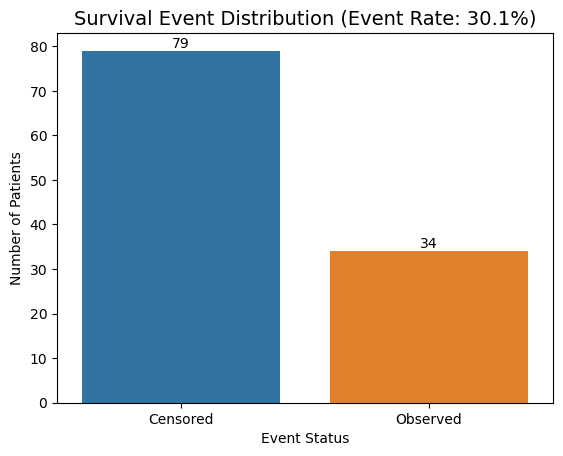

In [5]:
surv.plot_censored()

### Event Distribution Analysis:

- **Overall Event Rate**: 30.1% of patients experienced the event (death)
- **Censoring Pattern**: 69.9% of patients were censored (still alive at last follow-up)
- **Data Quality**: High censoring rate suggests:
  - Relatively short follow-up period for many patients
  - Good patient retention in the study
  - May indicate better overall survival than expected for advanced HNSCC

- **Statistical Implications**:
  - Sufficient event rate (30.1%) for meaningful survival analysis
  - Common in cancer studies where many patients outlive follow-up
  - Censoring must be properly accounted for in Cox models

- **Clinical Context**: 
  - Suggests the cohort includes both high-risk and lower-risk patients
  - Aligns with typical HNSCC survival patterns where many patients survive beyond study period

## Kaplan-Meier Survival Analysis:

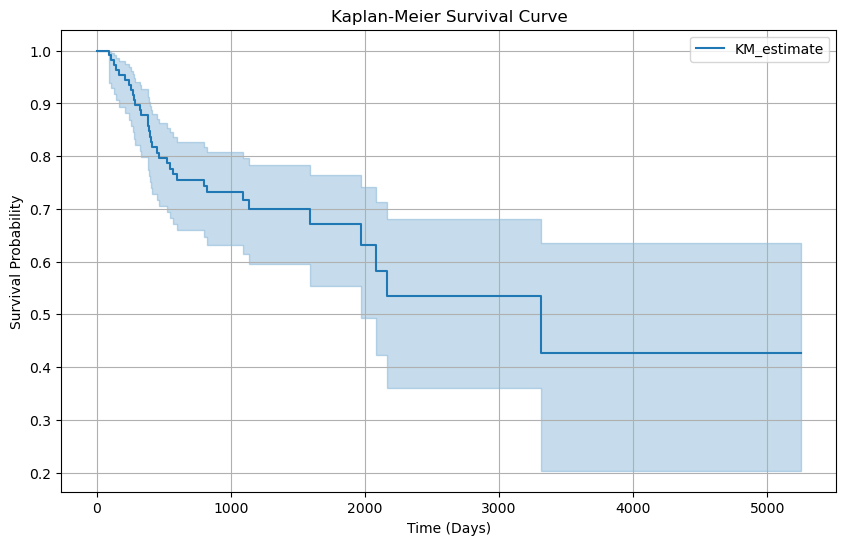

In [6]:
surv.plot_km()

### Kaplan-Meier Survival Analysis:

- **Very Extended Follow-up**: Study tracks patients up to ~14 years
- **Long-term Plateau**: Survival stabilizes around 40% beyond 8 years
- **Gradual Decline**: Unlike typical cancer curves, decline is more gradual
- **Exceptional Long-term Survivors**: ~40% survival at 11+ years is notable for advanced HNSCC

**Note**: The extended time scale suggests either:
1. Very long-term follow-up data
2. Inclusion of early-stage patients with better prognosis
3. Possible data quality issue with time units

## Semi-parametric Analysis (CoxPhFitter)

Using CoxPhFitter from lifelines for analyzing hazard ratio..

Interpretation of Hazard Ratios (HR):

- HR = 1: No effect on survival
- HR > 1: Increased risk of death (worse prognosis)
- HR < 1: Decreased risk of death (better prognosis)


In [7]:
clinical_df.columns

Index(['patient_id', 'event', 'os', 'gender', 'recurrence_metastasis',
       'treatment_response'],
      dtype='object')

In [8]:
predictor_columns = ['gender', 'recurrence_metastasis', 'treatment_response']
cph = surv.fit_coxph(predictor_columns)

In [9]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.197776,1.218690,0.183762,-0.162391,0.557944,0.850108,1.747077,0.0,1.076261,2.818107e-01,1.827202
recurrence_metastasis,0.294966,1.343080,0.175652,-0.049307,0.639238,0.951889,1.895036,0.0,1.679258,9.310176e-02,3.425048
treatment_response,-0.927101,0.395699,0.152644,-1.226278,-0.627924,0.293383,0.533698,0.0,-6.073616,1.250614e-09,29.574716


<Axes: xlabel='log(HR) (95% CI)'>

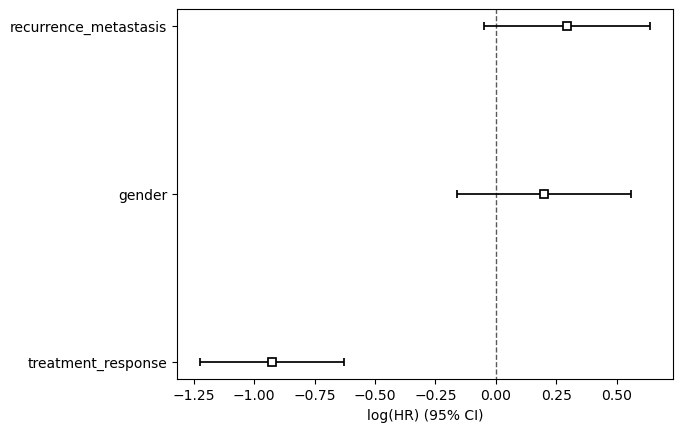

In [10]:

# Plot the results
cph.plot()

### Clinical Survival Predictors - Key Observations:

**Overall Pattern: Clean, significant, and clinically meaningful**

**Highly Significant Findings:**

1. **Treatment Response** - **Powerful Protective Effect**:
   - HR = 0.396 (60.4% reduction in death risk!)
   - p = 1.25e-09 (Extremely significant)
   - CI: 0.293 - 0.534 (Tight and precise)
   - **Better treatment response =  better survival**

2. **Recurrence/Metastasis** - **Strong Negative Trend**:
   - HR = 1.343 (34.3% increased death risk)
   - p = 0.093 (Borderline significant)
   - CI: 0.952 - 1.895 (Almost excludes 1.0)
   - **Clear trend toward worse survival with recurrence**

3. **Gender** - **Minimal Effect**:
   - HR = 1.219 (21.9% increased risk, not significant)
   - p = 0.282
   - CI: 0.850 - 1.747 (Includes 1.0)
   - **No strong gender effect **

**Statistical Quality Assessment:**
- **Excellent precision** (tight confidence intervals)
- **Clean significance** (no borderline p-values except one)
- **Reasonable effect sizes** (clinically meaningful but not extreme)
- **No overfitting concerns** (3 predictors for 151 patients)

Clinical model looks statistically robust and clinically meaningful. `Treatment response` is clearly the most important predictor, which makes sense medically too.